In [1]:
import pandas as pd

df= pd.read_csv("Data/opsd_germany_daily.csv")
df

,Date,Consumption,Wind,Solar,Wind+Solar
0,2006-01-01,1069.18400,NaN,NaN,NaN
1,2006-01-02,1380.52100,NaN,NaN,NaN
2,2006-01-03,1442.53300,NaN,NaN,NaN
3,2006-01-04,1457.21700,NaN,NaN,NaN
4,2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...,...
4378,2017-12-27,1263.94091,394.507,16.530,411.037
4379,2017-12-28,1299.86398,506.424,14.162,520.586
4380,2017-12-29,1295.08753,584.277,29.854,614.131
4381,2017-12-30,1215.44897,721.247,7.467,728.714


In [2]:
df['Date']= pd.to_datetime(df['Date'])
df= df.set_index('Date')
df

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-01,1069.18400,NaN,NaN,NaN
2006-01-02,1380.52100,NaN,NaN,NaN
2006-01-03,1442.53300,NaN,NaN,NaN
2006-01-04,1457.21700,NaN,NaN,NaN
2006-01-05,1477.13100,NaN,NaN,NaN
...,...,...,...,...
2017-12-27,1263.94091,394.507,16.530,411.037
2017-12-28,1299.86398,506.424,14.162,520.586
2017-12-29,1295.08753,584.277,29.854,614.131


In [4]:
df= df.resample("M").mean()
df

,Consumption,Wind,Solar,Wind+Solar
Date,,,,
2006-01-31,1461.442065,NaN,NaN,NaN
2006-02-28,1467.106893,NaN,NaN,NaN
2006-03-31,1418.649161,NaN,NaN,NaN
2006-04-30,1275.058900,NaN,NaN,NaN
2006-05-31,1253.488484,NaN,NaN,NaN
...,...,...,...,...
2017-08-31,1291.283022,177.412839,148.477677,325.890516
2017-09-30,1335.952031,209.591000,102.643033,312.234033
2017-10-31,1366.297385,402.583774,68.727645,471.311419


In [9]:
df.isna().sum()

Consumption    0
Wind           0
Solar          0
Wind+Solar     0
dtype: int64

In [8]:
df= df.dropna()

<Axes: xlabel='Date'>

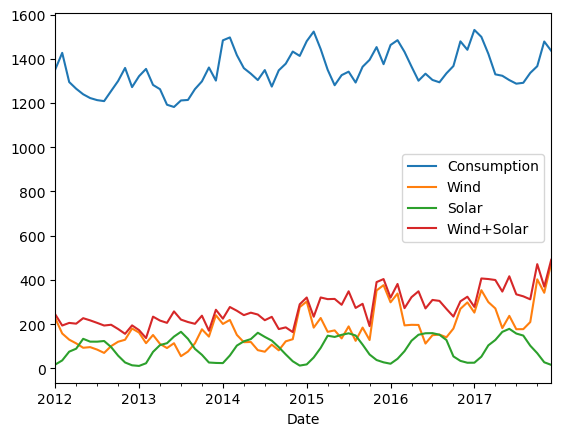

In [10]:
df.plot()